# Homework 8 (Due 03/01/2024)

In [1]:
# importing packages and custom modules
import sys
import numpy as np
from matplotlib import pyplot as plt
import astropy.units as u
import pandas as pd
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")


# importing custom functions
sys.path.append("../")
from ASTRO530 import plotting

---
## Question 17
### Part A

In [2]:
import pandas as pd

abundances = pd.read_csv("SolarAbundance.csv",delimiter=",")
partition_functions = pd.read_csv("partition_functions_T.csv",delimiter=",")

In [3]:
partition_functions = pd.read_csv("partition_functions_T.csv",delimiter=",") # modified table 
partition_functions = partition_functions.drop("Unnamed: 0",axis=1)
ionizations_nist = pd.read_csv("ionization_nist.csv",delimiter=",")

def partition_function(species,T):
    from scipy.optimize import curve_fit
    # import pandas as pd
    # import numpy as np

    if species == 'H-': # only depends on ionization energy, filled valence shell
        chi = 0.755 # eV
        U = 1*10**(-(chi*(5040/T)))
    elif species not in partition_functions.columns: # table is missing fully ionized elements, which have a constant partition function
        U = 1.
    else:
        def exponential_decay(x, a, b, c):
            return a * np.exp(-b * x) + c
        
        if species in partition_functions.columns[:-1]:
            y_values = np.array(list(partition_functions[species][:-1].values))  # Extracting values from DataFrame column
            thetas = partition_functions['theta'].values
            nan_mask = ~np.isnan(y_values)  # Create mask to remove NaN values
            y = y_values[nan_mask]
            x_values = thetas[:-1][nan_mask]
            x = np.array(x_values, dtype=float)
            try:
                popt, pcov = curve_fit(exponential_decay, x, y,) # fitting the points
                x_new = 5040/T
                logU = exponential_decay(x_new, *popt) # returns log value of U
                U = 10**logU
            except:
                # print('species',species,'cannot be fit with an exponential decay')
                U = 1.
    return U

def Phi(species,T):

    # import pandas as pd

    # assert (species in partition_functions.columns) or (species in ['H-','H+']), f'{species} is not an acceptable species to evaluate the partition function for lower state. Please use one of the following species:{["H-","H+"]+list(partition_functions.columns.values)}'
    assert (species in ionizations_nist['Species'].values) or (species in ['H-']), f'{species} is not an acceptable species to evaluate the ionization potential for lower state. Please use one of the following species:{["H-"]+list(ionizations_nist["Species"].values)}'
    
    if '-' not in species:
        species_1 = species + '+'
    else: 
        species_1 = species.replace('-','')

    # assert (species_1 in partition_functions.columns) or (species_1 in ['H-','H+']), f'{species_1} species not found; cannot calculate partition function for upper state.'

    U_r = partition_function(species,T)
    U_r1 = partition_function(species_1,T)
    if species == 'H-':
        chi = 0.755 #eV
    else:
        chi = ionizations_nist['Ionization Energy'].values[np.where(ionizations_nist['Species'].values == species)][0]

    phi_T = 0.6665*(U_r1/U_r)*(T**(5/2))*(10**(-(5040/T)*chi))
    return phi_T

In [4]:
def log_P_e(T,log_P_g,tol=1e-8,return_convergence=False):
    # making first guess of P_e
    if T > 30000:
        P_e = 0.5*10**log_P_g
    else:
        P_e = np.sqrt(Phi('H',T)*10**log_P_g)
        
    abundances = pd.read_csv("SolarAbundance.csv",delimiter=",")

    if return_convergence == True:
        delta_P_e_array = []
        log_P_e_array = [np.log10(P_e)]
        iterations = [0]

    delta_P_e = None
    iteration = 0
    while True:
        iteration += 1
        numerator = 0
        denominator = 0
        for i,element in enumerate(abundances['element'].values):
            A = abundances['A'][i]
            if A == A:
                Phi_T = Phi(element,T)
                frac = (Phi_T/P_e)/(1 + Phi_T/P_e)
                numerator += (A*frac)
                denominator += (A*(1 + frac))
        P_e_new = (10**log_P_g)*numerator/denominator

        delta_P_e = abs(P_e - P_e_new)/P_e_new
        
        if delta_P_e is not None and delta_P_e < tol: # testing if the percent change is less than tolerance
            print(f"Convergence found after {iteration} iterations!")
            # print(f"The value of log_P_e after convergence was reached:",np.log10(P_e))
            print(f"---------------------------")
            break
        if iteration > 500:
            print("Too many iterations.")
            print("Latest percent difference:",delta_P_e)
            print(f"---------------------------")
            break

        if return_convergence == True:
            delta_P_e_array.append(delta_P_e)
            log_P_e_array.append(np.log10(P_e_new))
            iterations.append(iteration)
            
        P_e = P_e_new

    if return_convergence == True:
        return np.log10(P_e), log_P_e_array, delta_P_e_array, iterations
    else:
        return np.log10(P_e)
            
        

24.00140130989607
Convergence found after 82 iterations!
---------------------------


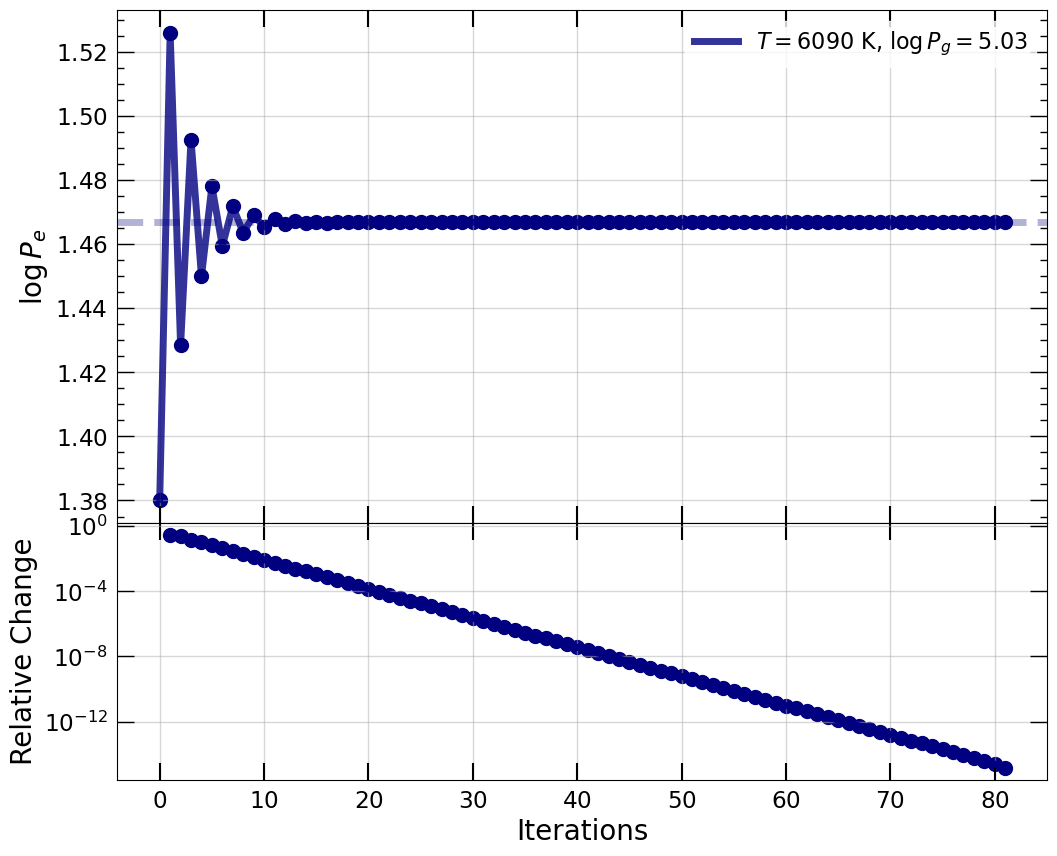

In [22]:
import matplotlib.ticker as mtick

fig = plt.figure(figsize=(12,10))
grid = plt.GridSpec(3,1,wspace=0,hspace=0)

ax1 = fig.add_subplot(grid[0:2,0])
ax2 = fig.add_subplot(grid[2,0])

colors = ['navy']
# for i,T in enumerate([5045,5540,5777]):
#     log_P_g = [4.53,4.85,4.95][i]
for i,T in enumerate([6090]):
    log_P_g = [5.03][i]
    log_P_e_val, log_P_e_array, delta_P_e_array, iterations = log_P_e(T,log_P_g,tol=1e-15,return_convergence=True)
    ax1.axhline(log_P_e_val,linestyle='dashed',c=colors[i],lw=5,alpha=0.3)
    ax1.plot(iterations,log_P_e_array,c=colors[i],lw=5,alpha=0.8,label=fr'$T={T}$ K, $\log P_g={log_P_g}$')
    ax1.scatter(iterations,log_P_e_array,c=colors[i],s=100)
    
    ax2.scatter(iterations[1:],delta_P_e_array,c=colors[i],s=100)
    ax2.plot(iterations[1:],delta_P_e_array,c=colors[i],lw=5)
    ax2.axhline(0,lw=2,c='gray')

ax1.set_xticklabels([])

ax1.legend()
ax1.set_ylabel(r'$\log P_e$')
ax2.set_ylabel(r'Relative Change')
ax2.set_xlabel(r'Iterations')
# ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5f'))
ax1.grid(alpha=0.5)
ax2.grid(alpha=0.5)
ax2.set_xlim(ax1.get_xlim())

ax2.set_yscale('log')
ax2.set_yscale('log')

plt.savefig("../Plots/HW8/Pe_convergence_single_temp.pdf", bbox_inches='tight')
plt.show()

0.7286211055635516
Convergence found after 23 iterations!
---------------------------
4.788743335919169
Convergence found after 33 iterations!
---------------------------
10.156022314340035
Convergence found after 47 iterations!
---------------------------


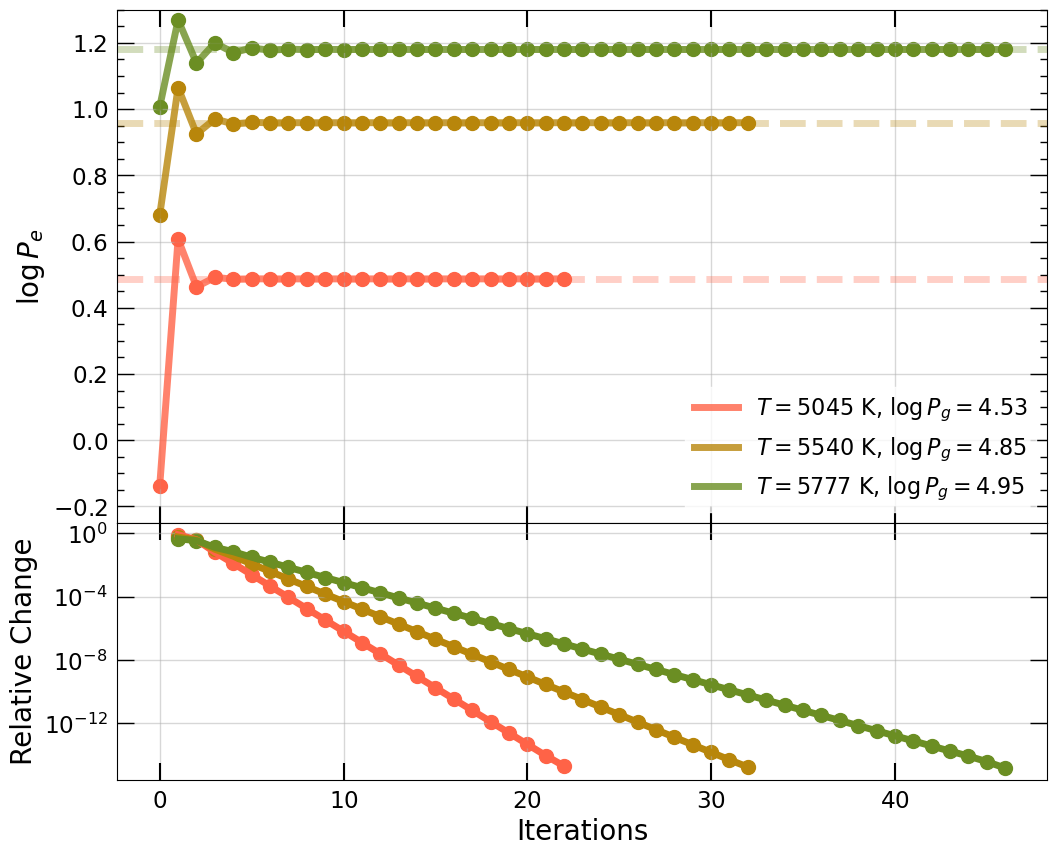

In [24]:
import matplotlib.ticker as mtick

fig = plt.figure(figsize=(12,10))
grid = plt.GridSpec(3,1,wspace=0,hspace=0)

ax1 = fig.add_subplot(grid[0:2,0])
ax2 = fig.add_subplot(grid[2,0])

colors = ['tomato','darkgoldenrod','olivedrab']
for i,T in enumerate([5045,5540,5777]):
    log_P_g = [4.53,4.85,4.95][i]
# for i,T in enumerate([8718]):
#     log_P_g = [5.24][i]
    log_P_e_val, log_P_e_array, delta_P_e_array, iterations = log_P_e(T,log_P_g,tol=1e-15,return_convergence=True)
    ax1.axhline(log_P_e_val,linestyle='dashed',c=colors[i],lw=5,alpha=0.3)
    ax1.plot(iterations,log_P_e_array,c=colors[i],lw=5,alpha=0.8,label=fr'$T={T}$ K, $\log P_g={log_P_g}$')
    ax1.scatter(iterations,log_P_e_array,c=colors[i],s=100)
    
    ax2.scatter(iterations[1:],delta_P_e_array,c=colors[i],s=100)
    ax2.plot(iterations[1:],delta_P_e_array,c=colors[i],lw=5)
    ax2.axhline(0,lw=2,c='gray')

ax1.set_xticklabels([])

ax1.legend()
ax1.set_ylabel(r'$\log P_e$')
ax2.set_ylabel(r'Relative Change')
ax2.set_xlabel(r'Iterations')
# ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5f'))
ax1.grid(alpha=0.5)
ax2.grid(alpha=0.5)
ax2.set_xlim(ax1.get_xlim())
ax1.set_ylim(-0.25,1.3)

ax2.set_yscale('log')
ax2.set_yscale('log')

plt.savefig("../Plots/HW8/Pe_convergence_multiple_temps.pdf", bbox_inches='tight')
plt.show()

0.007377828660855749
Convergence found after 10 iterations!
---------------------------
0.009694080932653655
Convergence found after 11 iterations!
---------------------------
0.012295448573995723
Convergence found after 11 iterations!
---------------------------
0.015993818053670006
Convergence found after 12 iterations!
---------------------------
0.020452263273698344
Convergence found after 12 iterations!
---------------------------
0.026600695003412344
Convergence found after 12 iterations!
---------------------------
0.03410329482872187
Convergence found after 13 iterations!
---------------------------
0.04489526488749458
Convergence found after 13 iterations!
---------------------------
0.058589388988843805
Convergence found after 13 iterations!
---------------------------
0.07931264974408365
Convergence found after 13 iterations!
---------------------------
0.11178437949223768
Convergence found after 14 iterations!
---------------------------
0.16659317784051517
Convergence foun

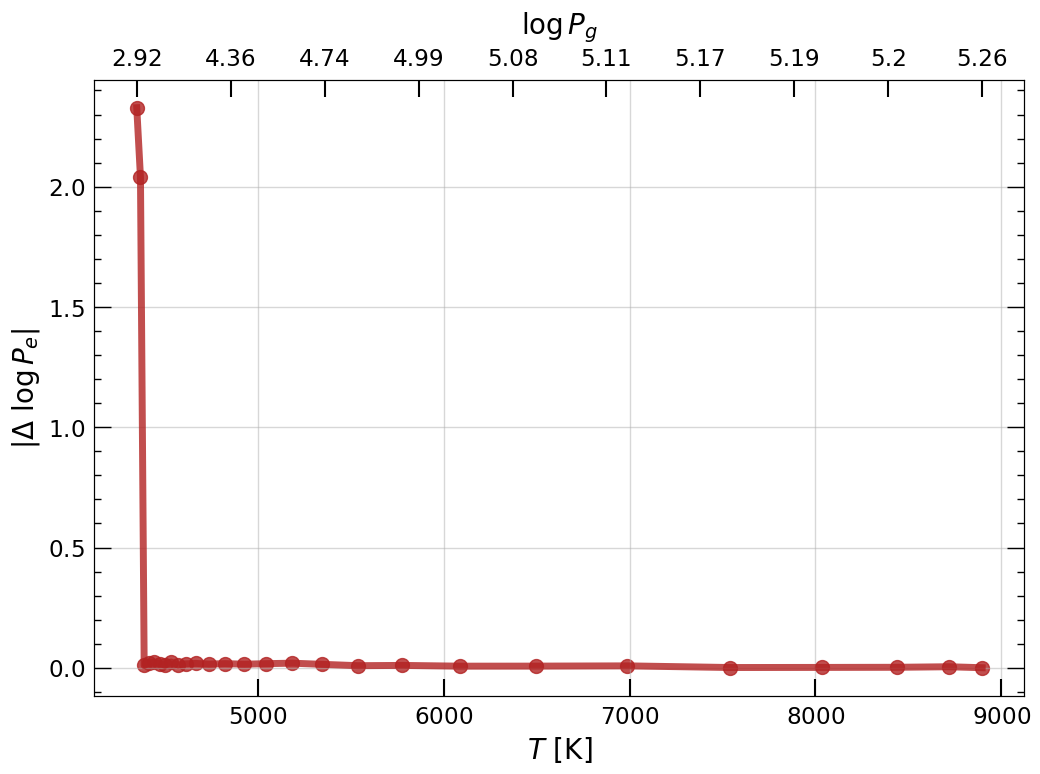

In [33]:
gray_table = pd.read_csv("gray_table_9.3.csv")

log_P_e_vals = []
num_iterations = []
for i,T in enumerate(gray_table['T'].values):
    log_P_g = gray_table['log P_g'].values[i]
    log_P_e_val, log_P_e_array, delta_P_e_array, iterations =log_P_e(T,log_P_g,tol=1e-8,return_convergence=True)
    log_P_e_vals.append(log_P_e_val)
    num_iterations.append(len(iterations)-1) # number of iterations to converge

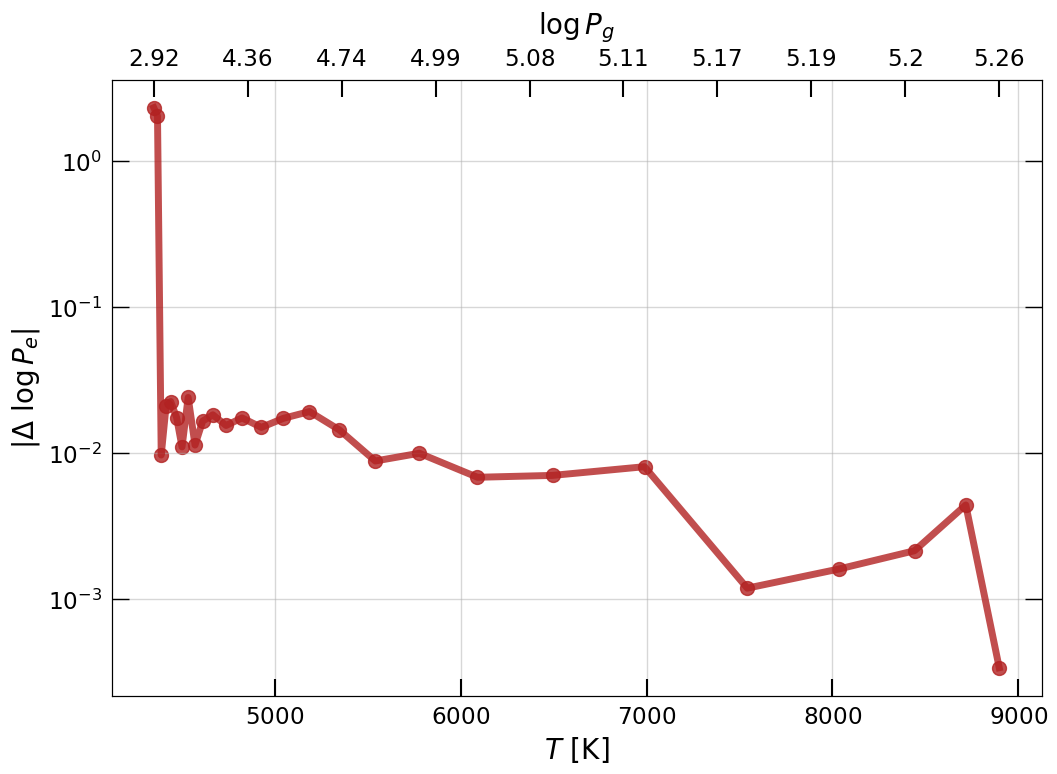

In [35]:
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(gray_table['T'],(abs(gray_table['log P_e'] - log_P_e_vals)),c='firebrick',s=100,alpha=0.8)
ax.plot(gray_table['T'],(abs(gray_table['log P_e'] - log_P_e_vals)),lw=5,c='firebrick',alpha=0.8)
ax.set_ylabel(r"$\left|  \Delta \ \log P_e \right|$")
ax.set_xlabel(r"$T \ \mathrm{[K]}$")
ax.grid(alpha=0.5)
ax.set_yscale('log')

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Sample data
x = gray_table['T']
y = gray_table['log P_g']

def polynomial_curve(x, *params):
    return np.polyval(params, x)

# Fit the curve to the data
degree = 8  # Degree of the polynomial
initial_guess = np.ones(degree + 1)  # Initial guess for the parameters
params, covariance = curve_fit(polynomial_curve, x, y, p0=initial_guess)

# Generate points for the fitted curve
T_array = np.linspace(np.min(x), np.max(x), 10)

# Specify the tick positions and labels for the top axis
top_tick_positions = np.array(T_array)  # Example tick positions for top axis
top_tick_labels = np.array([round(x,2) for x in np.array(polynomial_curve(T_array, *params))])  # Example tick labels for top axis

# Create a twin axis for the top axis
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

# Set the tick positions and labels for the top axis
ax2.set_xticks(top_tick_positions)
ax2.set_xticklabels(top_tick_labels)
ax2.set_xlabel(r"$\log P_g$",labelpad=10)

plt.savefig(f"../Plots/HW8/delta_logPe.pdf", bbox_inches='tight')
plt.show()

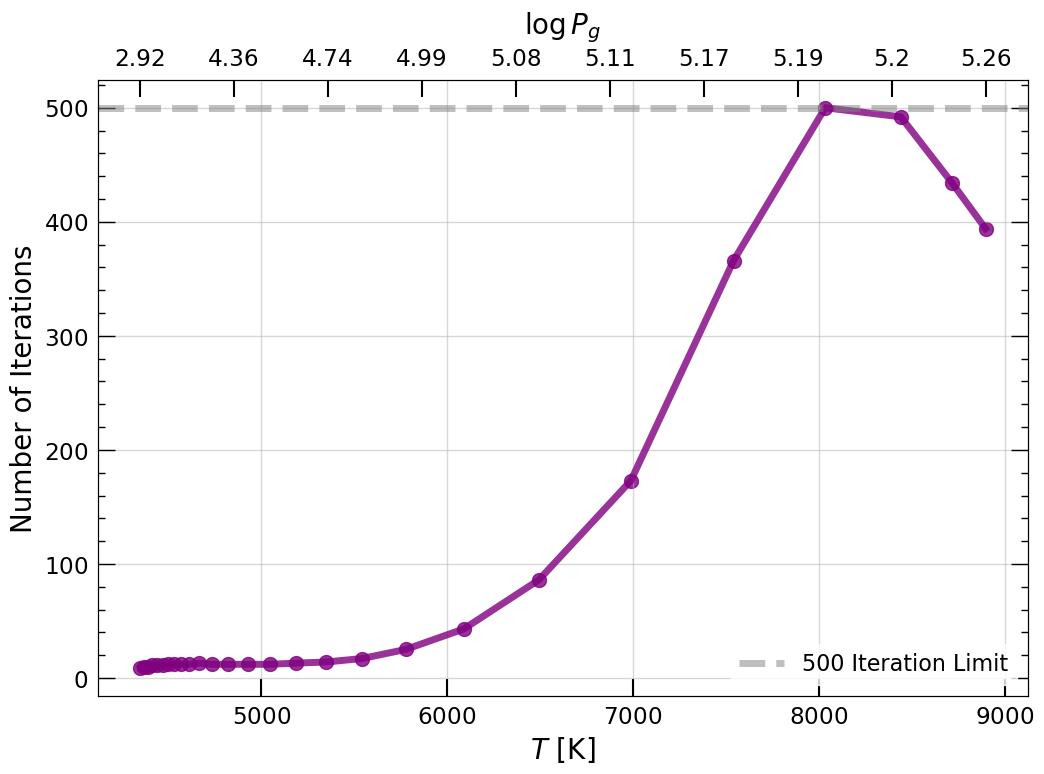

In [38]:
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(gray_table['T'],num_iterations,c='purple',s=100,alpha=0.8)
ax.plot(gray_table['T'],num_iterations,lw=5,c='purple',alpha=0.8)
ax.axhline(500,linestyle='dashed',lw=5,c='gray',alpha=0.5,label='500 Iteration Limit')
ax.legend()
ax.set_ylabel(r"Number of Iterations")
ax.set_xlabel(r"$T \ \mathrm{[K]}$")
ax.grid(alpha=0.5)
# ax.set_xscale('log')

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Sample data
x = gray_table['T']
y = gray_table['log P_g']

def polynomial_curve(x, *params):
    return np.polyval(params, x)

# Fit the curve to the data
degree = 8  # Degree of the polynomial
initial_guess = np.ones(degree + 1)  # Initial guess for the parameters
params, covariance = curve_fit(polynomial_curve, x, y, p0=initial_guess)

# Generate points for the fitted curve
T_array = np.linspace(np.min(x), np.max(x), 10)

# Specify the tick positions and labels for the top axis
top_tick_positions = np.array(T_array)  # Example tick positions for top axis
top_tick_labels = np.array([round(x,2) for x in np.array(polynomial_curve(T_array, *params))])  # Example tick labels for top axis

# Create a twin axis for the top axis
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

# Set the tick positions and labels for the top axis
ax2.set_xticks(top_tick_positions)
ax2.set_xticklabels(top_tick_labels)
ax2.set_xlabel(r"$\log P_g$",labelpad=10)

plt.savefig(f"../Plots/HW8/num_iterations.pdf", bbox_inches='tight')
plt.show()

---
### Part B

In [18]:
A_sum = 0
amu_sum = 0
for i in range(30):
    A_sum += abundances['A'].values[i]
    amu_sum += abundances['weight'].values[i] * abundances['A'].values[i]

print('For the 30 lightest elements, the sum of abundances is', A_sum, 'and the sum of the abundance-weighted masses is',amu_sum,'amu.' )

For the 30 lightest elements, the sum of abundances is 1.0861752053727 and the sum of the abundance-weighted masses is 1.367107621952563 amu.


---
### Part C

In [21]:
A_sum = 0
amu_sum = 0
for i in range(2,abundances.shape[0]):
    A = abundances['A'].values[i]
    if A != A:
        A = 0
    A_sum += A
    amu_sum += abundances['weight'].values[i] * A

print('For the', abundances.shape[0],'lightest elements (excluding H and He), the sum of abundances is', A_sum, 'and the sum of the abundance-weighted masses is',amu_sum,'amu.' )

For the 92 lightest elements (excluding H and He), the sum of abundances is 0.0010752126721989992 and the sum of the abundance-weighted masses is 0.018453079261262224 amu.
